In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

<h2><center> CSCI - UA 9472 - Artificial Intelligence </center></h2>

<h3><center> Assignment 4: Reinforcement Learning </center></h3>

<center>Given date: December 7
</center>
<center><font color='red'>Due date: December 20/21 </font>
</center>
<center><b>Total: 20 pts </b>
</center>


<center>In this fourth assignment, we will continue our quest for the optimal agent and replace our heavy logical reasoning model with a faster implementation based on Q-learning</center>

<img src="MonsterKill.png" width="400" height="300"/>



#### Question 1. A simple moving agent (10pts)

We consider a simple environment as shown below. Our simple agent has the possibility to move West, East, North and South (except on the borders of the environment). Moreover it has two additional actions:
    
   - It can hit with its sword (which is essentially useful when facing the skeleton)
    
   - It can open the door and escape the room (useful when being in the upper rightmost cell)
   
As you can imagine, hitting while in an empty cell is a loss of energy and should be penalized. We will thus associate useless behaviors (like hitting when alone and opening non existing doors) with a negative reward of -10. Hitting the skeleton and opening the door _when the skeleton has been killed_ should be associated with higher rewards of +30. Escaping without the kill will be associated with a negative reward of -10 (The agent should not exit before getting rid of all the evil in the room)

There are a total of 48 cells. Each cell can contain the skeleton, be empty or contain the door (exclusively) which makes a total of $48\times3 = 144$ states for your environment. Moreover, we want to keep track of whether or not the skeleton has been killed so we will take into account an additional variable encoding whether the kill has been completed. This thus leads to a total of $48\times 3\times2 = 288$.

Any move will be associated with a small penalty of -1 point    

<img src="mazeAssignment3a.png" width="400" height="300"/>


Start by coding a simple TD Q-learning agent which stores the Q-table entirely as a $288\times 6$ numpy array. Use an exploration function to avoid being stuck in a limited region of the environment. Recall that such a function can be defined as 

$$\begin{align}
f(Q_\theta[s,a], N[s,a]) = \left\{\begin{array}{ll}
R^+& \text{if $N[s,a]<N_e$}\\
Q_\theta[s,a]&\text{otherwise}
\end{array}\right. 
\end{align}$$

where $R^+$ is an estimate of the best possible reward that can be obtained in any state.

Concretely for each new state and action, you should update the $Q$-table after incrementing the count $N[s,a]$ (of the number of times action $a$ has been taken in state $s$) 

\begin{align}
Q[s, a] & \leftarrow Q[s,a] +\eta \left(N_{sa}[s,a]\right)\left(r+\gamma \max_{a'} Q[s',a'] - Q[s,a]\right)\\
s,a,r &\leftarrow s', \underset{a'}{\operatorname{argmax}} f\left(Q[s',a'], N[s',a']\right), r'
\end{align}

$\eta \left(N_{sa}[s,a]\right)$ is a learning rate that can be set to a sufficiently small constant or be evolving as the inverse of $N[s, a]$ 

Consider a couple of episodes to make sure that you fill out a sufficient number of entries in the table. Interlace the learning phases with a couple of evaluation phases during which you should store the number of steps needed to complete the kill and exit so that you will be able to plot the evolution of your agent at the end of the simulation. 

You can associate a negative reward with the impossible actions corresponding to hitting walls on the borders of the environment.

In [2]:
# set up

action_space = ['up','down','left','right','hit','leave']

cells = list(itertools.product(np.arange(8),np.arange(6)))
cell_states = ['empty','skeleton','door']
skeleton_states = ['alive','dead']
state_space = list(itertools.product(cells,cell_states,skeleton_states))

state2int = {k: v for v, k in enumerate(state_space)}
action2int = {k: v for v, k in enumerate(action_space)}

door = (7, 5)
skeleton = (3, 3)

In [3]:
gamma = .2
ne = 5

In [4]:
# aux functions

def learning_rate(n):
    return 1/(1+n)

def f(q, n):
    if n < ne: return 10000
    return q

def action_selection(Q, N, s):
    return np.argmax([f(Q[s, a], N[s, a]) for a in range(6)])

def next_state(s, a):
    '''
    all variables are encoded int
    this function returns the new state and the reward. 
    '''
    
    state = deepcopy(state_space[s])
    cell, cell_state, skeleton_state = state
    x,y = cell
    
    action = action_space[a]
    reward = -1
    # y in range(7), x in range(8)
    if action == 'up':        
        if y == 5: 
            reward += -5
        else:
            y+=1
    if action == 'down':
        if y == 0: 
            reward += -5
        else:
            y-=1
    if action == 'left':
        if x == 0: 
            reward += -5
        else:
            x = x-1
    if action == 'right':
        if x == 7: 
            reward += -5
        else:
            x =  x+1
    if action == 'hit':
        if cell == skeleton and skeleton_state == 'alive':
            reward = 30
            skeleton_state = 'dead'
        else:
            reward = -10
    elif action == 'leave':
        if cell == door and skeleton_state == 'dead':
            return None,30
        else:
            reward = -10

    if (x,y) == door:
        cell_state = 'door'
    elif (x,y) == skeleton:
        cell_state = 'skeleton'
    else:
        cell_state = 'empty'
    
    state = ((x,y),cell_state, skeleton_state)
    return state2int[state],reward
    


In [5]:
num_evaluations = 100
Q = np.zeros((288,6))
N = np.zeros((288,6))
time_to_completion = np.zeros((num_evaluations,))

In [6]:
for k in range(num_evaluations):
    
    print('epoch ',k,end=': ')
    # train for a couple of epochs
    for episode in range(200):
        s = 0
        while s != None:
            a = action_selection(Q,N,s)
            s_,r = next_state(s,a)
            Q[s,a] = Q[s,a] + learning_rate(N[s,a])*\
                (r + gamma*np.max(Q[s_,:]) -Q[s,a])
            N[s,a] += 1
            s = s_
        if episode%10 == 0:
            print('.',end='')
        
    # Then evaluate the agent 

    step_count = 0

    s = 0    
    while s != None:
        a = action_selection(Q, N, s)
        s_, r = next_state(s, a)
        # should I update the Q table here? If I don't update it, it will likely to loop forever. 
        Q[s, a] = Q[s, a] + learning_rate(N[s, a]) *\
            (r + gamma*np.max(Q[s_, :]) - Q[s, a])
        N[s, a] += 1
        s = s_
        step_count += 1
    time_to_completion[k] = step_count
    print('evaluation',step_count)
    


epoch  0: ....................evaluation 16
epoch  1: ....................evaluation 18
epoch  2: ....................evaluation 14
epoch  3: ....................evaluation 20
epoch  4: ....................evaluation 18
epoch  5: ....................evaluation 14
epoch  6: ....................evaluation 16
epoch  7: ....................evaluation 14
epoch  8: ....................evaluation 14
epoch  9: ....................evaluation 36
epoch  10: ....................evaluation 14
epoch  11: ....................evaluation 14
epoch  12: ....................evaluation 14
epoch  13: ....................evaluation 14
epoch  14: ....................evaluation 14
epoch  15: ....................evaluation 14
epoch  16: ....................evaluation 14
epoch  17: ....................evaluation 42
epoch  18: ....................evaluation 16
epoch  19: ....................evaluation 14
epoch  20: ....................evaluation 14
epoch  21: ....................evaluation 14
epoch  22: .........

Text(0, 0.5, 'steps')

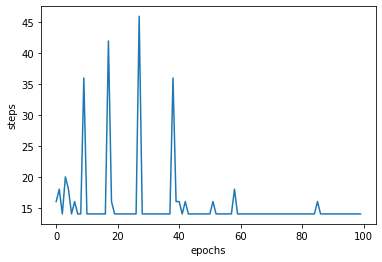

In [7]:
plt.plot(time_to_completion)
plt.xlabel('epochs')
plt.ylabel('steps')

It seems that my Q-table converged, at the very last epochs

#### Question 2. The parametric model (15pts)

We now want to improve the generalization skills of our agent. We will encode our $Q$-table as a simple feedforward neural network. To avoid losing time with the implementation, we will rely on keras for the architecture (see below). We will consider a **simple one hidden layer** network that takes as **input** a vector encoding the current state of the environment (note that such a vector can be encoded in various ways, for example as a $5$-tuple including the cartesian coordinates of the agent and 3 variables indicating whether there is a door, skeleton,..) and returns as **output** the value associated with each of the actions. In other words we consider a parametric model $f_\theta\in \mathbb{R}^{|a|}$ such that $[f_{\theta}(s)]_a \approx Q[s, a]$. Recall that the TD update for such a model is given

\begin{align}
\theta_i &\leftarrow \theta_i + \alpha \left[R[s] + \gamma \max_{a'} \hat{Q}_{\theta}[s',a'] - \hat{Q}[s,a]\right]\frac{\partial \hat{Q}_\theta[s,a]}{\partial \theta_i} 
\end{align}

- Start by updating the weights after each new step (in an SGD fashion) and evaluate the agent as before by interlacing your training with a couple of evaluation step where you should compute the time needed to exit with the kill completed. 


- We will then be a little wiser and keep track of a short memory before updating the network. 

Consider the following steps :

   - Initialize the memory to an empty vector
   
    
   - As before, we will consider a number of episodes. For each episode, we will consider a full simulation (until exiting with the kill). Again you should rely on some exploration function to alternate between exploration and exploitation (selection of the action corresponding to the maximum output of the network for the current state). 
   
    
   - After each action, observe the reward and store the tuple $(s_t, a_t, r_t, s_{t+1})$ and store it in the memory. 
   
    
   - Select a random minibatch from the memory and update the networks through a gradient update on the minibatch (mb) 
    
    $$\min_{\theta_i} \frac{1}{\text{size}(\text{mb})}\sum_{t\in \text{mb}}\left(R[s_t] + \gamma \max_{a_{t+1}} \hat{Q}_{\theta}[s_{t+1},a_{t+1}] - \hat{Q}_\theta[s_t,a_t]\right)^2 $$



- To see how to build a Feedforward neural network in keras, the simplest approach is to use the method 'add' such as in

        model = keras.Sequential()
        model.add(layers.Dense(n, activation="relu"))

    you can see [here](https://keras.io/guides/sequential_model/) for more details.
    
    
    
- Once you have built the model, you need to select an optimizer before you can train it. This can be implemented through the ['compile method'](https://keras.io/api/optimizers/)

          model.compile(optimizer='SGD',
          loss='mean_squared_error',
          metrics=['accuracy'])
          
- Finally to train the network, you can rely on the fit function (see also [here](https://keras.io/api/models/model_training_apis/))

        model.fit(train_data, train_labels,epochs=5)
        
Note that Keras (when using 'compile' with the SGD option) relies on a default batch of size 32 so either you should specify a smaller batch size or you should make sure your memory is sufficiently big. Also note that as written above we will in fact do a coule of SGD iterations (one for each sample in the minibatch, repeated epochs times).  

In [15]:
def vectorize_state(s):
    pos, cell_state, skeleton_state = deepcopy(state_space[s])
    x,y = pos
    ret = [x,y]
    ret.append(int(cell_state == 'empty'))
    ret.append(int(cell_state == 'skeleton'))
    ret.append(int(cell_state == 'door'))
    ret.append(int(skeleton_state == 'alive'))
    return np.array(ret)

In [14]:
num_evaluations = 10
time_to_completion = np.zeros((num_evaluations,))

In [24]:
model = Sequential([
    keras.Input(shape=(6,)), # dimension 6 for the state space input. 
    layers.Dense(32,activation='relu'),# hidden layer
    layers.Dense(6) # output the values of each action. 
])

model.compile(optimizer='SGD',loss='mean_squared_error',metrics=['accuracy'])

In [6]:
for k in range(num_evaluations):
    
    print('epoch ',k,end=': ')
    mem = []
    for episode in range(200):
        s = 0
        while s != None:
            a = action_selection(Q,N,s)
            s_,r = next_state(s,a)
            Q[s,a] = Q[s,a] + learning_rate(N[s,a])*\
                (r + gamma*np.max(Q[s_,:]) -Q[s,a])
            N[s,a] += 1
            s = s_
        if episode%10 == 0:
            print('.',end='')
        
    # Then evaluate the agent 

    step_count = 0

    s = 0    
    while s != None:
        a = action_selection(Q, N, s)
        s_, r = next_state(s, a)
        # should I update the Q table here? If I don't update it, it will likely to loop forever. 
        Q[s, a] = Q[s, a] + learning_rate(N[s, a]) *\
            (r + gamma*np.max(Q[s_, :]) - Q[s, a])
        N[s, a] += 1
        s = s_
        step_count += 1
    time_to_completion[k] = step_count
    print('evaluation',step_count)
    


epoch  0: ....................evaluation 16
epoch  1: ....................evaluation 18
epoch  2: ....................evaluation 14
epoch  3: ....................evaluation 20
epoch  4: ....................evaluation 18
epoch  5: ....................evaluation 14
epoch  6: ....................evaluation 16
epoch  7: ....................evaluation 14
epoch  8: ....................evaluation 14
epoch  9: ....................evaluation 36
epoch  10: ....................evaluation 14
epoch  11: ....................evaluation 14
epoch  12: ....................evaluation 14
epoch  13: ....................evaluation 14
epoch  14: ....................evaluation 14
epoch  15: ....................evaluation 14
epoch  16: ....................evaluation 14
epoch  17: ....................evaluation 42
epoch  18: ....................evaluation 16
epoch  19: ....................evaluation 14
epoch  20: ....................evaluation 14
epoch  21: ....................evaluation 14
epoch  22: .........

#### Question 3. (5pts) 

Compare and plot the improvement in the behavior of your agent for a couple of neural networks architectures. Don't make the network overly complicated. You can just try different activation functions with different numbers of units per layers (possibly also consider a _small_ number of hidden layers)